In [1]:
import nltk
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import re
import string

In [2]:
path = 'dataset_tweets_WHO.txt'

#convert the text to json
with open(path) as f:
    tweets_json = json.load(f)

In [3]:
print(json.dumps(tweets_json['50'], indent=4, sort_keys=True))

{
    "contributors": null,
    "coordinates": null,
    "created_at": "Mon Oct 11 04:43:20 +0000 2021",
    "display_text_range": [
        0,
        140
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "urls": [],
        "user_mentions": [
            {
                "id": 3794682452,
                "id_str": "3794682452",
                "indices": [
                    3,
                    11
                ],
                "name": "World Health Organization (WHO) Western Pacific",
                "screen_name": "WHOWPRO"
            }
        ]
    },
    "favorite_count": 0,
    "favorited": false,
    "full_text": "RT @WHOWPRO: \u201cMy patients are no different to my grandmother and grandfather.\u201d \n\nLoyal to their oath, health workers like Dr Gantsengel Pur\u2026",
    "geo": null,
    "id": 1447422540335484932,
    "id_str": "1447422540335484932",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_repl

In [4]:
def remove_punct(line):
    """
    Helper function to remove punctuation EXCEPT for '#''
    
    Arugment:
    line -- string of text
    
    Returns:
    line -- string of text without punctuation
    """
    return line.translate(str.maketrans('', '', string.punctuation.replace('#', '')))

def build_terms(line):
    """
    Preprocess the Tweet text by removing stop words, emojis, and punctuation and
    stemming, transforming to lowercase and returning the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line -- a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    
    # transform to lowercase 
    line =  line.lower() 
    
    # remove non-ASCII terms like emojis and symbols
    line = "".join(c for c in line if c in string.printable) 
    
    # remove punctuation EXCEPT for hashtags (see remove_punct())
    line = remove_punct(line)
    
    # tokenize the text to get a list of terms
    line = line.split() 
    
    # remove html tags, blank spaces like '', and urls
    line = [word for word in line if not (re.match("^qampa$" , word) or re.match("^amp$" , word) or re.match("^http" , word)) 
    and word] 
    
    # remove standalone numbers e.x. '19' but not the 19 from 'covid19'
    line = [word for word in line if not word.isnumeric()]
    
    # add standalone word as token too if it has number e.x. 'covid19' gets tokenized as 'covid19' and 'covid'
    line = line + [word.rstrip(string.digits) for word in line if sum([c.isdigit() for c in word]) != 0]
    
    # remove stopwords
    line = [word for word in line if word not in stop_words] 
    
    # perform stemming
    line = [stemmer.stem(word) for word in line]
    
    # add unhashtagged word if it's hashtag is present 
    # e.x. if #covid is present, we also add covid as a token
    line = line + [word.replace('#', '') for word in line if word[0] == '#' ] 
    
    return line

In [5]:
# tweet_dict is our output data structure that maps Tweet IDs to their text
# note we need to keep the following information
# Tweet | Username | Date | Hashtags | Likes | Retweets | Url

def create_tweets(tweets_json):
    tweet_dict = defaultdict()
    tweets = []

    for key in tweets_json:
        tweet_data = {
            'id': tweets_json[key]['id'],
            'full_text': tweets_json[key]['full_text'],
            'tokens': build_terms(tweets_json[key]['full_text']),
            'username': tweets_json[key]['user']['name'],
            'date': tweets_json[key]['created_at'],
            'hashtags': [key['text'] for key in tweets_json[key]['entities']['hashtags']],
            'likes': tweets_json[key]['favorite_count'],
            'retweets': tweets_json[key]['retweet_count'], 
        }

        #sometimes the tweet url doesn't exist
        try:
            tweet_data['url'] = tweets_json[key]['entities']['media'][0]['url']
        except:
            tweet_data['url'] = None
        
        tweets.append(tweet_data)
    return tweets


In [6]:
# create index
def create_index(tweets_json):
    tweets = create_tweets(tweets_json)
    index = defaultdict(list)
    title_index = defaultdict()

    for tweet in tweets:
        title_index[tweet['id']] = tweet
        
        #current page index keeps track of postision of each word in tweet
        #e.x. if our tweet #50 has tokens "covid health world covid", our current_page_index looks like:
        # {covid -> [50, [0, 3]], health -> [50, [1]], world [50, [2]]}
        current_page_index = {}
        for position, word in enumerate(tweet['tokens']):
            
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[word][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[word]=[tweet['id'], array('I', [position])] #'I' indicates unsigned int (int in Python)
        

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
    
    return index, title_index


In [7]:
# apply tf-idf
# tweets is a list of tokens
def create_tfidf_index(tweets):
    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    title_index = defaultdict()
    idf = defaultdict(float)


    for tweet in tweets:
        
        title_index[tweet['id']] = tweet
        current_page_index = {}

        for position, term in enumerate(tweet['tokens']):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[tweet['id'], array('I',[position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            
            #CHECK THIS!
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = 1 + np.round(np.log(float(len(tweets)/df[term])), 4)

    return index, tf, df, idf, title_index

def test():
    tweet1 = {'tokens' : ['covid', 'health', 'world', 'covid'], 'id' : 50}
    tweet2 = {'tokens' : ['covid', 'medicine', 'dog', 'world'], 'id' : 60}
    tweet3 = {'tokens' : ['covid', 'health', 'dog', 'ugh', 'huh'], 'id' : 2}
    tweets = [tweet1, tweet2, tweet3]
    index, tf, df, idf, title_index = create_tfidf_index(tweets)
    print(index)
    print(tf)
    print(df)
    print(idf)
    print(title_index)
test()

defaultdict(<class 'list'>, {'covid': [[50, array('I', [0, 3])], [60, array('I', [0])], [2, array('I', [0])]], 'health': [[50, array('I', [1])], [2, array('I', [1])]], 'world': [[50, array('I', [2])], [60, array('I', [3])]], 'medicine': [[60, array('I', [1])]], 'dog': [[60, array('I', [2])], [2, array('I', [2])]], 'ugh': [[2, array('I', [3])]], 'huh': [[2, array('I', [4])]]})
defaultdict(<class 'list'>, {'covid': [0.8165, 0.5, 0.4472], 'health': [0.4082, 0.4472], 'world': [0.4082, 0.5], 'medicine': [0.5], 'dog': [0.5, 0.4472], 'ugh': [0.4472], 'huh': [0.4472]})
defaultdict(<class 'int'>, {'covid': 3, 'health': 2, 'world': 2, 'medicine': 1, 'dog': 2, 'ugh': 1, 'huh': 1})
defaultdict(<class 'float'>, {'covid': 1.0, 'health': 1.4055, 'world': 1.4055, 'medicine': 2.0986000000000002, 'dog': 1.4055, 'ugh': 2.0986000000000002, 'huh': 2.0986000000000002})
defaultdict(None, {50: {'tokens': ['covid', 'health', 'world', 'covid'], 'id': 50}, 60: {'tokens': ['covid', 'medicine', 'dog', 'world'], 'i

In [8]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    doc_vectors = defaultdict(lambda: [0] * len(terms)) 
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_pred_score = [x[0] for x in doc_scores]

    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, result_pred_score

In [9]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs = docs.union(set(term_docs))
            #docs = set(term_docs)
            #print(docs)
        except:
            #term is not in index
            pass
        

    docs = list(docs)
    ranked_docs, pred_score = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs, pred_score

In [10]:
import time
tweets = create_tweets(tweets_json)
start_time = time.time()
index, tf, df, idf, title_index = create_tfidf_index(tweets)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 112.21 seconds


In [11]:
def pretty_print_tweet(tweet):
    print(
    """id: {}
    username: {}
    text: {}
    date: {}
    hashtags: {}
    likes: {}
    retweets: {}
    url: {}\n""".format(tweet['id'], tweet['username'], tweet['full_text'], tweet['date'], tweet['hashtags'], tweet['likes'],
                        tweet['retweets'], tweet['url']))

In [12]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
count = 1
#print(ranked_docs[0])
for d_id in ranked_docs[:top]:
    print("rank: {}".format(count))
    #print(d_id)
    #print(title_index)
    pretty_print_tweet(title_index[d_id])
    count += 1

Insert your query (i.e.: Computer Science):

covid

Top 10 results out of 735 for the searched query:

rank: 1
id: 1446089970758860801
    username: World Health Organization (WHO)
    text: 🆕 WHO clinical case definition for post #COVID19 condition, also called 'long COVID' https://t.co/WoiLcwsgJX https://t.co/Z0olrHlWPC
    date: Thu Oct 07 12:28:10 +0000 2021
    hashtags: ['COVID19']
    likes: 723
    retweets: 373
    url: https://t.co/Z0olrHlWPC

rank: 2
id: 1447421491428143106
    username: World Health Organization (WHO)
    text: RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…
    date: Mon Oct 11 04:39:10 +0000 2021
    hashtags: ['COVID19']
    likes: 0
    retweets: 71
    url: None

rank: 3
id: 1422159909957869572
    username: World Health Organization (WHO)
    text: If you have recovered from #COVID19 but are still experiencing certain symptoms you could have post COVID-19 cond

# Evaluation

In [13]:
# we'll print terms with highest df, tf, and idf

#print(sorted(df.items(), key=lambda x: x[1], reverse=True)[:500], "\n")
#print(sorted(tf.items(), key=lambda x: x[1], reverse=True)[:50], "\n")
print(sorted(idf.items(), key=lambda x: x[1], reverse=True)[:50], "\n")
print(df)

[('multiti', 8.7828), ('marginalis', 8.7828), ('algeria', 8.7828), ('#algeria', 8.7828), ('16th', 8.7828), ('pop', 8.7828), ('si', 8.7828), ('completament', 8.7828), ('vacunado', 8.7828), ('contraer', 8.7828), ('importa', 8.7828), ('todava', 8.7828), ('esperando', 8.7828), ('#inform', 8.7828), ('verifi', 8.7828), ('miser', 8.7828), ('immor', 8.7828), ('arent', 8.7828), ('nine', 8.7828), ('ep', 8.7828), ('#climateactioncal', 8.7828), ('climateactioncal', 8.7828), ('#healthworkersworldwid', 8.7828), ('#climateactionbi', 8.7828), ('healthworkersworldwid', 8.7828), ('climateactionbi', 8.7828), ('worldchang', 8.7828), ('#helacel', 8.7828), ('lacksfamili', 8.7828), ('#healthequ', 8.7828), ('helacel', 8.7828), ('healthequ', 8.7828), ('#climateactionprotect', 8.7828), ('climateactionprotect', 8.7828), ('goodwil', 8.7828), ('momgerm', 8.7828), ('reimagin', 8.7828), ('environmentstransportmobl', 8.7828), ('healthierfairergreen', 8.7828), ('outofschool', 8.7828), ('ictfacilit', 8.7828), ('intim',

In [14]:
import random
import pandas as pd
import numpy as np

# query 0 for example
query = 'covid'

random.seed(101)

# We create a DataFrame with the results of the seacrh (doc_id and pred_rel of the ranked docs)
doc_ids, scores = search_tf_idf(query, index)
rows = []
for i in range(len(scores)):
     rows.append([0, doc_ids[i], scores[i], random.randint(0, 1)])
    
df = pd.DataFrame(rows ,columns=["q_id", "doc_id", "predicted_relevance", "y_true"])

df.head()

,q_id,doc_id,predicted_relevance,y_true
0,0,1446089970758860801,2.460673,0
1,0,1447421491428143106,2.311527,1
2,0,1422159909957869572,2.260064,1
3,0,1418678505328451584,2.130931,0
4,0,1416433609091653633,2.079469,0


In [15]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = sum(y_true == 1)
    return relevant / k 

In [54]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''

    gtp = np.sum(y_true == 1) 
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])           

    ## if all docs are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    
    for i in range(len(y_true)):
        try:
            if y_true[i] == 1:
                n_relevant_at_i += 1 
                prec_at_i += n_relevant_at_i / (i + 1) 
        except:
            pass
            
    return prec_at_i / gtp

In [47]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(y_true == 1) + 1) # hint: to get the position of the first relevant document use "np.argmax"

In [48]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = (2 ** y_true) - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10): 
    order = np.argsort(y_true)[::-1]
    ideal = np.take(y_true, order[:k])
    dcg_max = dcg_at_k(ideal, ideal, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k)/dcg_max, 4)  # return ndcg@k

In [58]:
#calculate metrics
k = 50
def calculate_metrics(query, k):
    doc_ids, scores = search_tf_idf(query, index)
    rows = []
    for i in range(len(scores)):
        rows.append([0, doc_ids[i], scores[i], random.randint(0, 1)])   
    df = pd.DataFrame(rows ,columns=["q_id", "doc_id", "predicted_relevance", "y_true"])
    
    prec_k = precision_at_k(df['y_true'], df['predicted_relevance'], k)
    avg_prec_k = avg_precision_at_k(df['y_true'], df['predicted_relevance'], k)
    
    rr_k = rr_at_k(df['y_true'], df['predicted_relevance'], k)
    dcg_k = dcg_at_k(df['y_true'], df['predicted_relevance'], k)
    ndcg_k = ndcg_at_k(df['y_true'], df['predicted_relevance'], k)
    
    return prec_k, avg_prec_k, rr_k, dcg_k, ndcg_k
    
    
    
queries = ['covid', 'vaccine', 'global health', 'end pandemic', 'death risk']
for query in queries:
    print(query)
    prec_k, avg_prec_k, _, dcg_k, ndcg_k = calculate_metrics(query, k)
    print('precision@k | avg_presicion@k | dcg@k | ndcg@k')
    print(prec_k, avg_prec_k, dcg_k, ndcg_k)

covid
precision@k | avg_presicion@k | dcg@k | ndcg@k
0.58 0.04212808452495567 7.5339936628568065 0.5841
vaccine
precision@k | avg_presicion@k | dcg@k | ndcg@k
0.36 0.026894825439014 4.073617172652326 0.3158
global health
precision@k | avg_presicion@k | dcg@k | ndcg@k
0.44 0.02651358543472982 5.5375231266178595 0.4293
end pandemic
precision@k | avg_presicion@k | dcg@k | ndcg@k
0.46 0.100415039758598 6.714912695781696 0.5206
death risk
precision@k | avg_presicion@k | dcg@k | ndcg@k
0.48 0.09687357235114219 5.66991008342434 0.4396


In [19]:
RRs = []
for q in df['q_id'].unique(): # loop over all query ids
    labels = np.array(df[df['q_id']==q]['y_true']) # get labels for current query
    scores = np.array(df[df['q_id']==q]['predicted_relevance']) # get predicted score for current query
    RRs.append(rr_at_k(labels,scores)) # append RR for current query
mrr = np.round(float(sum(RRs)/len(RRs)),4) # Mean RR at current k
print("MRR for the queries is : " +str(mrr))

av_at_k = [avg_precision_at_k(df0['y_true'], df0['predicted_relevance']),avg_precision_at_k(df1['y_true'], df1['predicted_relevance']),avg_precision_at_k(df2['y_true'], df2['predicted_relevance']),avg_precision_at_k(df3['y_true'], 
df3['predicted_relevance']),avg_precision_at_k(df4['y_true'], df4['predicted_relevance'])]

AttributeError: 'list' object has no attribute 'data'

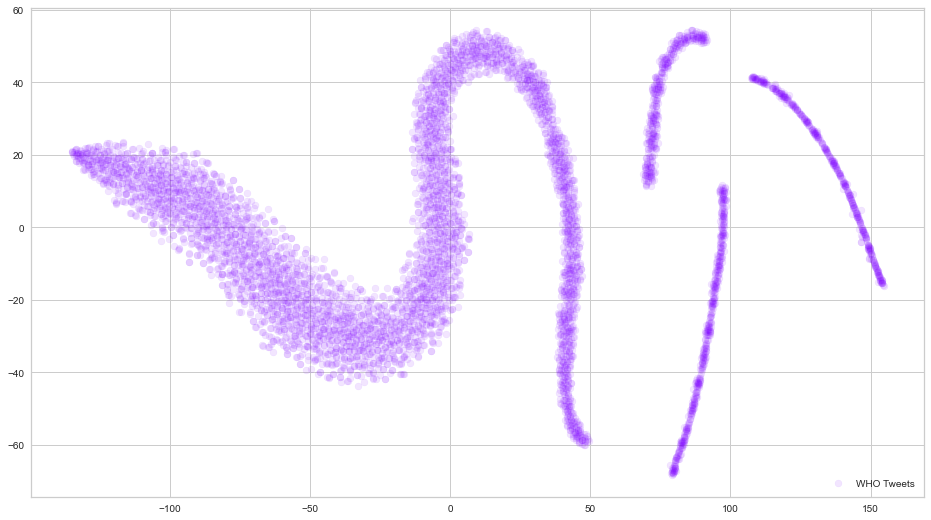

In [20]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import numpy as np

sentences = []
for key in tweets_json:
    sentences.append(build_terms(tweets_json[key]['full_text']))


model_ak = Word2Vec(sentences, min_count=1, size=100)

words_ak = []
embeddings_ak = []
for word in list(model_ak.wv.vocab):
    embeddings_ak.append(model_ak.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    #plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
 

tsne_plot_2d('WHO Tweets', embeddings_ak_2d, a=0.1)